# Environment with Obstacles

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import remove_polygons, remove_circle_patches
from sgptools.models.continuous_sgp import *

np.random.seed(0)
tf.random.set_seed(0)

2024-05-05 12:06:31.254102: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 12:06:31.255677: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 12:06:31.287785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 12:06:31.288584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 12:06:31.884850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

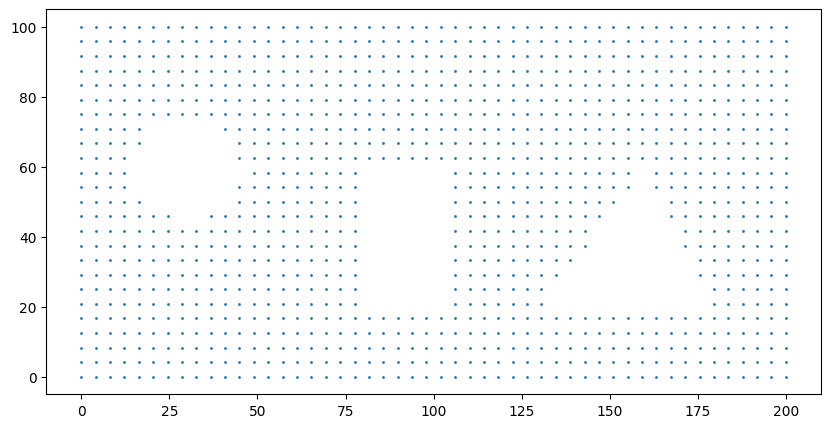

(1089, 2) (1089, 1)


In [2]:
# Generate synthetic training data
data_dims = (50, 25)
x = np.linspace(0, 200, data_dims[0])
y = np.linspace(0, 100, data_dims[1])
X, Y = np.meshgrid(x, y)

X, Y = remove_circle_patches(X, Y, [plt.Circle((30, 60), 15)])
X, Y = remove_polygons(X, Y, [[[80, 20], [105, 20], [105, 60], [80, 60]],])
X, Y = remove_polygons(X, Y, [[[130, 20], [180, 20], [160, 60]],])

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=1)
plt.show()

X_train = np.array([X, Y]).T
y_train = np.zeros((X_train.shape[0], 1))
X_train = X_train.astype(float)
y_train = y_train.astype(float)
print(X_train.shape, y_train.shape)

In [3]:
num_inducing = 200

# Get initial GP parameters
_, noise_variance, rbf = get_model_params(np.zeros((1, 2)), np.zeros((1, 1)), 
                             lengthscales=12.3254, 
                             variance=0.561265,
                             noise_variance=2e-6,
                             max_steps=0)

# Optimize the inducing points/sensor locations
sgpr, _ = continuous_sgp(num_inducing,
                         X_train,
                         kernel=rbf,
                         noise_variance=noise_variance,
                         lr=1e-2,
                         max_steps=5000)
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.56126 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 12.3254  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

2024-05-05 12:06:36.005564: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


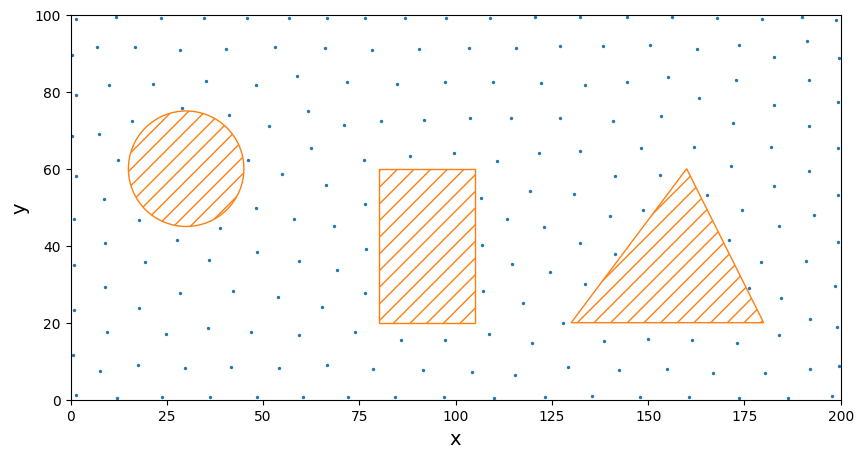

In [4]:
# Plot the sensor locations and the obstacles
plt.figure(figsize=(10, 5))
plt.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], 
            color='C0', 
            s=2, 
            label='Solution Placements')

ax = plt.gca()
ax.add_patch(plt.Polygon([[80, 20], [105, 20], [105, 60], [80, 60]], 
             fill=None, hatch='//', color='C1', label='Obstacle'))
ax.add_patch(plt.Polygon([[130, 20], [180, 20], [160, 60]], 
             fill=None, hatch='//', color='C1'))
ax.add_patch(plt.Circle((30, 60), 15, 
             fill=None, hatch='//', color='C1'))
ax.set_aspect('equal')

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.xlim(0, 200)
plt.ylim(0, 100)

plt.show()

# Note that all the solution placements avoid the obstacles